<a href="https://colab.research.google.com/github/wojciechteclaw/SimpleNeuralNetworkFromScratch/blob/master/NeuralNetworkFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 54442627.35it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1732589.02it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14238168.60it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2541086.94it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [6]:
training_data = []
testing_data = []
for data in trainset:
    res = [data[1]] + data[0].flatten().tolist()
    training_data.append(res)

for data in testset:
    res = [data[1]] + data[0].flatten().tolist()
    testing_data.append(res)

len(training_data), len(testing_data)

(60000, 10000)

In [7]:
column_names = ['label']
for i in range(len(training_data[0]) - 1):
    column_names.append(f"pixel{i}")

In [8]:
trainig_pd = pd.DataFrame(training_data, columns=column_names)
testing_pd = pd.DataFrame(testing_data, columns=column_names)

In [9]:
train_set = np.array(trainig_pd)
test_set = np.array(testing_pd)

In [10]:
data = np.array(trainig_pd)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]

data_train = data[1000:].T
Y_train = data_train[0]
X_train = data_train[1:]

In [11]:
X_dev.shape, Y_dev.shape, X_train.shape, Y_train.shape

((784, 1000), (1000,), (784, 59000), (59000,))

In [1]:
def init_params():
    W1 = np.random.rand(32, 784) - 0.5
    b1 = np.random.rand(32, 1) - 0.5
    W2 = np.random.rand(10, 32) - 0.5
    b2 = np.random.rand(10, 1) - 0.5

    return W1, b1, W2, b2

def ReLU(X):
    return np.maximum(0, X)

def softmax(X):
    shift_X = X - np.max(X, axis=0, keepdims=True)
    exps = np.exp(shift_X)
    return exps / np.sum(exps, axis=0, keepdims=True)

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(Y):
    one_hot_Y = np.zeros((Y_train.size, Y_train.max().astype(int) + 1))
    one_hot_Y[np.arange(Y_train.size), Y_train.astype(int)] = 1
    return one_hot_Y.T

def deriv_ReLU(X):
    return X > 0

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1

    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2

    return W1, b1, W2, b2

In [14]:
from tqdm import tqdm

def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(Y_pred, Y):
    return np.sum(Y_pred == Y) / Y.size

def gradient_descent(X, Y, epochs, lr):
    W1, b1, W2, b2 = init_params()
    for epoch in tqdm(range(epochs)):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)
        if epoch % 5 == 0:
            print(f"\n\nEpoch: {epoch}")
            print(f"Accuracy: {get_accuracy(get_predictions(A2), Y)}")


    return W1, b1, W2, b2

In [15]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 1500, 0.05)

  0%|          | 1/1500 [00:00<18:37,  1.34it/s]



Epoch: 0
Accuracy: 0.10911864406779662


  0%|          | 6/1500 [00:05<22:34,  1.10it/s]



Epoch: 5
Accuracy: 0.2254406779661017


  1%|          | 11/1500 [00:09<18:32,  1.34it/s]



Epoch: 10
Accuracy: 0.29466101694915253


  1%|          | 16/1500 [00:12<18:02,  1.37it/s]



Epoch: 15
Accuracy: 0.3345762711864407


  1%|▏         | 21/1500 [00:17<23:01,  1.07it/s]



Epoch: 20
Accuracy: 0.36427118644067796


  2%|▏         | 26/1500 [00:21<19:19,  1.27it/s]



Epoch: 25
Accuracy: 0.39089830508474577


  2%|▏         | 31/1500 [00:24<17:52,  1.37it/s]



Epoch: 30
Accuracy: 0.417


  2%|▏         | 36/1500 [00:28<17:26,  1.40it/s]



Epoch: 35
Accuracy: 0.44305084745762713


  3%|▎         | 41/1500 [00:33<21:43,  1.12it/s]



Epoch: 40
Accuracy: 0.4670677966101695


  3%|▎         | 46/1500 [00:36<18:07,  1.34it/s]



Epoch: 45
Accuracy: 0.4907627118644068


  3%|▎         | 51/1500 [00:40<17:32,  1.38it/s]



Epoch: 50
Accuracy: 0.510864406779661


  4%|▎         | 56/1500 [00:45<23:30,  1.02it/s]



Epoch: 55
Accuracy: 0.5308813559322034


  4%|▍         | 61/1500 [00:49<22:32,  1.06it/s]



Epoch: 60
Accuracy: 0.5486101694915254


  4%|▍         | 66/1500 [00:53<18:00,  1.33it/s]



Epoch: 65
Accuracy: 0.5636949152542373


  5%|▍         | 71/1500 [00:57<20:55,  1.14it/s]



Epoch: 70
Accuracy: 0.5784237288135593


  5%|▌         | 76/1500 [01:01<19:22,  1.23it/s]



Epoch: 75
Accuracy: 0.5934915254237288


  5%|▌         | 81/1500 [01:05<17:25,  1.36it/s]



Epoch: 80
Accuracy: 0.6056440677966102


  6%|▌         | 86/1500 [01:09<16:57,  1.39it/s]



Epoch: 85
Accuracy: 0.616406779661017


  6%|▌         | 91/1500 [01:13<22:17,  1.05it/s]



Epoch: 90
Accuracy: 0.6262881355932204


  6%|▋         | 96/1500 [01:17<17:32,  1.33it/s]



Epoch: 95
Accuracy: 0.6358983050847458


  7%|▋         | 101/1500 [01:21<16:54,  1.38it/s]



Epoch: 100
Accuracy: 0.6449322033898305


  7%|▋         | 106/1500 [01:25<21:17,  1.09it/s]



Epoch: 105
Accuracy: 0.6542033898305085


  7%|▋         | 111/1500 [01:30<20:40,  1.12it/s]



Epoch: 110
Accuracy: 0.6617796610169492


  8%|▊         | 116/1500 [01:33<17:14,  1.34it/s]



Epoch: 115
Accuracy: 0.6693898305084746


  8%|▊         | 121/1500 [01:37<17:05,  1.34it/s]



Epoch: 120
Accuracy: 0.6759152542372882


  8%|▊         | 126/1500 [01:42<19:57,  1.15it/s]



Epoch: 125
Accuracy: 0.6829152542372882


  9%|▊         | 131/1500 [01:45<16:56,  1.35it/s]



Epoch: 130
Accuracy: 0.6885423728813559


  9%|▉         | 136/1500 [01:49<16:28,  1.38it/s]



Epoch: 135
Accuracy: 0.6942033898305084


  9%|▉         | 141/1500 [01:54<24:55,  1.10s/it]



Epoch: 140
Accuracy: 0.6999491525423729


 10%|▉         | 146/1500 [01:58<18:49,  1.20it/s]



Epoch: 145
Accuracy: 0.7047118644067797


 10%|█         | 151/1500 [02:02<16:30,  1.36it/s]



Epoch: 150
Accuracy: 0.7095762711864407


 10%|█         | 156/1500 [02:06<19:26,  1.15it/s]



Epoch: 155
Accuracy: 0.7146949152542373


 11%|█         | 161/1500 [02:10<17:59,  1.24it/s]



Epoch: 160
Accuracy: 0.7193728813559322


 11%|█         | 166/1500 [02:14<16:24,  1.36it/s]



Epoch: 165
Accuracy: 0.723813559322034


 11%|█▏        | 171/1500 [02:18<16:11,  1.37it/s]



Epoch: 170
Accuracy: 0.7277457627118644


 12%|█▏        | 176/1500 [02:23<20:11,  1.09it/s]



Epoch: 175
Accuracy: 0.7321186440677966


 12%|█▏        | 181/1500 [02:26<16:40,  1.32it/s]



Epoch: 180
Accuracy: 0.7361186440677966


 12%|█▏        | 186/1500 [02:30<15:45,  1.39it/s]



Epoch: 185
Accuracy: 0.7397118644067796


 13%|█▎        | 191/1500 [02:34<20:19,  1.07it/s]



Epoch: 190
Accuracy: 0.7433050847457627


 13%|█▎        | 196/1500 [02:38<17:00,  1.28it/s]



Epoch: 195
Accuracy: 0.7471694915254238


 13%|█▎        | 201/1500 [02:42<15:43,  1.38it/s]



Epoch: 200
Accuracy: 0.7503559322033898


 14%|█▎        | 206/1500 [02:45<15:30,  1.39it/s]



Epoch: 205
Accuracy: 0.7529491525423729


 14%|█▍        | 211/1500 [02:50<19:10,  1.12it/s]



Epoch: 210
Accuracy: 0.7557288135593221


 14%|█▍        | 216/1500 [02:54<16:07,  1.33it/s]



Epoch: 215
Accuracy: 0.7592033898305085


 15%|█▍        | 221/1500 [02:58<15:18,  1.39it/s]



Epoch: 220
Accuracy: 0.7616271186440678


 15%|█▌        | 226/1500 [03:02<19:33,  1.09it/s]



Epoch: 225
Accuracy: 0.7644915254237288


 15%|█▌        | 231/1500 [03:06<16:15,  1.30it/s]



Epoch: 230
Accuracy: 0.7672542372881356


 16%|█▌        | 236/1500 [03:09<15:13,  1.38it/s]



Epoch: 235
Accuracy: 0.7698813559322034


 16%|█▌        | 241/1500 [03:13<16:46,  1.25it/s]



Epoch: 240
Accuracy: 0.7728983050847458


 16%|█▋        | 246/1500 [03:18<17:47,  1.17it/s]



Epoch: 245
Accuracy: 0.7753898305084745


 17%|█▋        | 251/1500 [03:22<15:14,  1.37it/s]



Epoch: 250
Accuracy: 0.7778813559322034


 17%|█▋        | 256/1500 [03:25<15:08,  1.37it/s]



Epoch: 255
Accuracy: 0.7802033898305085


 17%|█▋        | 261/1500 [03:30<20:26,  1.01it/s]



Epoch: 260
Accuracy: 0.7822372881355932


 18%|█▊        | 266/1500 [03:34<15:28,  1.33it/s]



Epoch: 265
Accuracy: 0.7845593220338983


 18%|█▊        | 271/1500 [03:37<14:45,  1.39it/s]



Epoch: 270
Accuracy: 0.7864576271186441


 18%|█▊        | 276/1500 [03:41<17:34,  1.16it/s]



Epoch: 275
Accuracy: 0.7883559322033898


 19%|█▊        | 281/1500 [03:47<22:25,  1.10s/it]



Epoch: 280
Accuracy: 0.790593220338983


 19%|█▉        | 286/1500 [03:51<15:49,  1.28it/s]



Epoch: 285
Accuracy: 0.792593220338983


 19%|█▉        | 291/1500 [03:54<15:08,  1.33it/s]



Epoch: 290
Accuracy: 0.794593220338983


 20%|█▉        | 296/1500 [03:59<17:38,  1.14it/s]



Epoch: 295
Accuracy: 0.7964576271186441


 20%|██        | 301/1500 [04:03<14:58,  1.33it/s]



Epoch: 300
Accuracy: 0.7980847457627118


 20%|██        | 306/1500 [04:06<14:10,  1.40it/s]



Epoch: 305
Accuracy: 0.799677966101695


 21%|██        | 311/1500 [04:11<19:10,  1.03it/s]



Epoch: 310
Accuracy: 0.8010169491525424


 21%|██        | 316/1500 [04:15<15:14,  1.29it/s]



Epoch: 315
Accuracy: 0.8025254237288135


 21%|██▏       | 321/1500 [04:19<14:30,  1.35it/s]



Epoch: 320
Accuracy: 0.8041186440677967


 22%|██▏       | 326/1500 [04:23<15:41,  1.25it/s]



Epoch: 325
Accuracy: 0.8054576271186441


 22%|██▏       | 331/1500 [04:27<16:34,  1.18it/s]



Epoch: 330
Accuracy: 0.8068813559322033


 22%|██▏       | 336/1500 [04:31<14:15,  1.36it/s]



Epoch: 335
Accuracy: 0.8082033898305084


 23%|██▎       | 341/1500 [04:34<13:46,  1.40it/s]



Epoch: 340
Accuracy: 0.8094915254237288


 23%|██▎       | 346/1500 [04:39<18:52,  1.02it/s]



Epoch: 345
Accuracy: 0.8107966101694916


 23%|██▎       | 351/1500 [04:43<14:35,  1.31it/s]



Epoch: 350
Accuracy: 0.812135593220339


 24%|██▎       | 356/1500 [04:46<13:45,  1.39it/s]



Epoch: 355
Accuracy: 0.8135932203389831


 24%|██▍       | 361/1500 [04:51<16:25,  1.16it/s]



Epoch: 360
Accuracy: 0.8147457627118644


 24%|██▍       | 366/1500 [04:55<15:19,  1.23it/s]



Epoch: 365
Accuracy: 0.8157966101694916


 25%|██▍       | 371/1500 [04:58<13:51,  1.36it/s]



Epoch: 370
Accuracy: 0.8169152542372882


 25%|██▌       | 376/1500 [05:02<13:22,  1.40it/s]



Epoch: 375
Accuracy: 0.8178135593220339


 25%|██▌       | 381/1500 [05:07<17:32,  1.06it/s]



Epoch: 380
Accuracy: 0.819


 26%|██▌       | 386/1500 [05:10<13:59,  1.33it/s]



Epoch: 385
Accuracy: 0.8201525423728814


 26%|██▌       | 391/1500 [05:14<13:22,  1.38it/s]



Epoch: 390
Accuracy: 0.8212203389830508


 26%|██▋       | 396/1500 [05:18<16:16,  1.13it/s]



Epoch: 395
Accuracy: 0.8223050847457627


 27%|██▋       | 401/1500 [05:23<14:35,  1.25it/s]



Epoch: 400
Accuracy: 0.8233728813559322


 27%|██▋       | 406/1500 [05:26<13:22,  1.36it/s]



Epoch: 405
Accuracy: 0.8244237288135593


 27%|██▋       | 411/1500 [05:30<13:02,  1.39it/s]



Epoch: 410
Accuracy: 0.8253728813559322


 28%|██▊       | 416/1500 [05:35<16:22,  1.10it/s]



Epoch: 415
Accuracy: 0.8263559322033899


 28%|██▊       | 421/1500 [05:38<13:27,  1.34it/s]



Epoch: 420
Accuracy: 0.8272203389830508


 28%|██▊       | 426/1500 [05:42<12:48,  1.40it/s]



Epoch: 425
Accuracy: 0.8281016949152542


 29%|██▊       | 431/1500 [05:46<16:31,  1.08it/s]



Epoch: 430
Accuracy: 0.8289152542372882


 29%|██▉       | 436/1500 [05:50<14:19,  1.24it/s]



Epoch: 435
Accuracy: 0.8297796610169491


 29%|██▉       | 441/1500 [05:54<12:54,  1.37it/s]



Epoch: 440
Accuracy: 0.8305084745762712


 30%|██▉       | 446/1500 [05:57<12:29,  1.41it/s]



Epoch: 445
Accuracy: 0.8312033898305085


 30%|███       | 451/1500 [06:02<15:36,  1.12it/s]



Epoch: 450
Accuracy: 0.8319322033898305


 30%|███       | 456/1500 [06:06<12:48,  1.36it/s]



Epoch: 455
Accuracy: 0.8325084745762712


 31%|███       | 461/1500 [06:09<12:36,  1.37it/s]



Epoch: 460
Accuracy: 0.8332881355932203


 31%|███       | 466/1500 [06:14<16:25,  1.05it/s]



Epoch: 465
Accuracy: 0.8339491525423729


 31%|███▏      | 471/1500 [06:18<13:29,  1.27it/s]



Epoch: 470
Accuracy: 0.8345254237288136


 32%|███▏      | 476/1500 [06:21<12:26,  1.37it/s]



Epoch: 475
Accuracy: 0.8352542372881356


 32%|███▏      | 481/1500 [06:25<12:19,  1.38it/s]



Epoch: 480
Accuracy: 0.8360338983050848


 32%|███▏      | 486/1500 [06:30<14:46,  1.14it/s]



Epoch: 485
Accuracy: 0.836728813559322


 33%|███▎      | 491/1500 [06:34<12:28,  1.35it/s]



Epoch: 490
Accuracy: 0.837406779661017


 33%|███▎      | 496/1500 [06:37<11:57,  1.40it/s]



Epoch: 495
Accuracy: 0.8382372881355932


 33%|███▎      | 501/1500 [06:42<15:59,  1.04it/s]



Epoch: 500
Accuracy: 0.8388474576271187


 34%|███▎      | 506/1500 [06:46<12:49,  1.29it/s]



Epoch: 505
Accuracy: 0.8394915254237288


 34%|███▍      | 511/1500 [06:49<12:07,  1.36it/s]



Epoch: 510
Accuracy: 0.8402203389830508


 34%|███▍      | 516/1500 [06:53<12:49,  1.28it/s]



Epoch: 515
Accuracy: 0.8406440677966102


 35%|███▍      | 521/1500 [06:58<13:49,  1.18it/s]



Epoch: 520
Accuracy: 0.8413559322033898


 35%|███▌      | 526/1500 [07:01<11:48,  1.37it/s]



Epoch: 525
Accuracy: 0.8418474576271187


 35%|███▌      | 531/1500 [07:05<11:27,  1.41it/s]



Epoch: 530
Accuracy: 0.8423728813559322


 36%|███▌      | 536/1500 [07:09<15:27,  1.04it/s]



Epoch: 535
Accuracy: 0.8429661016949153


 36%|███▌      | 541/1500 [07:13<12:11,  1.31it/s]



Epoch: 540
Accuracy: 0.8436949152542373


 36%|███▋      | 546/1500 [07:17<11:26,  1.39it/s]



Epoch: 545
Accuracy: 0.8442033898305085


 37%|███▋      | 551/1500 [07:20<12:13,  1.29it/s]



Epoch: 550
Accuracy: 0.8447966101694915


 37%|███▋      | 556/1500 [07:25<13:20,  1.18it/s]



Epoch: 555
Accuracy: 0.8449661016949153


 37%|███▋      | 561/1500 [07:29<11:21,  1.38it/s]



Epoch: 560
Accuracy: 0.8455254237288136


 38%|███▊      | 566/1500 [07:32<11:02,  1.41it/s]



Epoch: 565
Accuracy: 0.8461355932203389


 38%|███▊      | 571/1500 [07:37<14:51,  1.04it/s]



Epoch: 570
Accuracy: 0.8465254237288136


 38%|███▊      | 576/1500 [07:40<11:30,  1.34it/s]



Epoch: 575
Accuracy: 0.8470677966101695


 39%|███▊      | 581/1500 [07:44<11:02,  1.39it/s]



Epoch: 580
Accuracy: 0.8475762711864406


 39%|███▉      | 586/1500 [07:48<12:51,  1.18it/s]



Epoch: 585
Accuracy: 0.8480508474576272


 39%|███▉      | 591/1500 [07:52<12:32,  1.21it/s]



Epoch: 590
Accuracy: 0.8483389830508474


 40%|███▉      | 596/1500 [07:56<10:59,  1.37it/s]



Epoch: 595
Accuracy: 0.8489152542372881


 40%|████      | 601/1500 [08:00<12:59,  1.15it/s]



Epoch: 600
Accuracy: 0.8493220338983051


 40%|████      | 606/1500 [08:09<25:40,  1.72s/it]



Epoch: 605
Accuracy: 0.8498474576271187


 41%|████      | 611/1500 [08:13<13:36,  1.09it/s]



Epoch: 610
Accuracy: 0.8501016949152542


 41%|████      | 616/1500 [08:17<11:00,  1.34it/s]



Epoch: 615
Accuracy: 0.8505423728813559


 41%|████▏     | 621/1500 [08:22<14:24,  1.02it/s]



Epoch: 620
Accuracy: 0.8509322033898306


 42%|████▏     | 626/1500 [08:25<11:11,  1.30it/s]



Epoch: 625
Accuracy: 0.8512203389830508


 42%|████▏     | 631/1500 [08:29<10:31,  1.38it/s]



Epoch: 630
Accuracy: 0.8517118644067797


 42%|████▏     | 636/1500 [08:33<11:45,  1.22it/s]



Epoch: 635
Accuracy: 0.8522033898305085


 43%|████▎     | 641/1500 [08:37<11:59,  1.19it/s]



Epoch: 640
Accuracy: 0.8525254237288136


 43%|████▎     | 646/1500 [08:41<10:32,  1.35it/s]



Epoch: 645
Accuracy: 0.852864406779661


 43%|████▎     | 651/1500 [08:45<10:17,  1.38it/s]



Epoch: 650
Accuracy: 0.8531355932203389


 44%|████▎     | 656/1500 [08:49<13:56,  1.01it/s]



Epoch: 655
Accuracy: 0.8534745762711864


 44%|████▍     | 661/1500 [08:53<10:48,  1.29it/s]



Epoch: 660
Accuracy: 0.8537457627118644


 44%|████▍     | 666/1500 [08:57<09:58,  1.39it/s]



Epoch: 665
Accuracy: 0.8541525423728814


 45%|████▍     | 671/1500 [09:01<12:03,  1.15it/s]



Epoch: 670
Accuracy: 0.854406779661017


 45%|████▌     | 676/1500 [09:05<11:09,  1.23it/s]



Epoch: 675
Accuracy: 0.8549152542372881


 45%|████▌     | 681/1500 [09:09<09:54,  1.38it/s]



Epoch: 680
Accuracy: 0.8552372881355932


 46%|████▌     | 686/1500 [09:12<09:40,  1.40it/s]



Epoch: 685
Accuracy: 0.8555084745762712


 46%|████▌     | 691/1500 [09:17<12:38,  1.07it/s]



Epoch: 690
Accuracy: 0.8557796610169491


 46%|████▋     | 696/1500 [09:21<10:10,  1.32it/s]



Epoch: 695
Accuracy: 0.8562542372881355


 47%|████▋     | 701/1500 [09:24<09:37,  1.38it/s]



Epoch: 700
Accuracy: 0.8564237288135593


 47%|████▋     | 706/1500 [09:29<11:34,  1.14it/s]



Epoch: 705
Accuracy: 0.8566949152542372


 47%|████▋     | 711/1500 [09:33<10:34,  1.24it/s]



Epoch: 710
Accuracy: 0.8570338983050847


 48%|████▊     | 716/1500 [09:36<09:33,  1.37it/s]



Epoch: 715
Accuracy: 0.8573898305084746


 48%|████▊     | 721/1500 [09:40<09:20,  1.39it/s]



Epoch: 720
Accuracy: 0.8576949152542372


 48%|████▊     | 726/1500 [09:45<11:35,  1.11it/s]



Epoch: 725
Accuracy: 0.8581016949152542


 49%|████▊     | 731/1500 [09:48<09:37,  1.33it/s]



Epoch: 730
Accuracy: 0.8582203389830508


 49%|████▉     | 736/1500 [09:52<09:18,  1.37it/s]



Epoch: 735
Accuracy: 0.858593220338983


 49%|████▉     | 741/1500 [09:57<12:00,  1.05it/s]



Epoch: 740
Accuracy: 0.8589152542372881


 50%|████▉     | 746/1500 [10:01<09:50,  1.28it/s]



Epoch: 745
Accuracy: 0.8592203389830508


 50%|█████     | 751/1500 [10:04<09:09,  1.36it/s]



Epoch: 750
Accuracy: 0.8595593220338983


 50%|█████     | 756/1500 [10:08<09:31,  1.30it/s]



Epoch: 755
Accuracy: 0.8597966101694915


 51%|█████     | 761/1500 [10:13<10:23,  1.19it/s]



Epoch: 760
Accuracy: 0.860135593220339


 51%|█████     | 766/1500 [10:16<09:05,  1.35it/s]



Epoch: 765
Accuracy: 0.8606610169491525


 51%|█████▏    | 771/1500 [10:20<08:55,  1.36it/s]



Epoch: 770
Accuracy: 0.8609830508474576


 52%|█████▏    | 776/1500 [10:25<11:52,  1.02it/s]



Epoch: 775
Accuracy: 0.8612033898305085


 52%|█████▏    | 781/1500 [10:29<09:05,  1.32it/s]



Epoch: 780
Accuracy: 0.8615084745762712


 52%|█████▏    | 786/1500 [10:32<08:44,  1.36it/s]



Epoch: 785
Accuracy: 0.8617118644067797


 53%|█████▎    | 791/1500 [10:36<10:03,  1.17it/s]



Epoch: 790
Accuracy: 0.8620169491525423


 53%|█████▎    | 796/1500 [10:41<09:31,  1.23it/s]



Epoch: 795
Accuracy: 0.8623389830508474


 53%|█████▎    | 801/1500 [10:44<08:35,  1.36it/s]



Epoch: 800
Accuracy: 0.862593220338983


 54%|█████▎    | 806/1500 [10:48<08:16,  1.40it/s]



Epoch: 805
Accuracy: 0.8627627118644068


 54%|█████▍    | 811/1500 [10:53<10:54,  1.05it/s]



Epoch: 810
Accuracy: 0.8630338983050847


 54%|█████▍    | 816/1500 [10:56<08:41,  1.31it/s]



Epoch: 815
Accuracy: 0.8633220338983051


 55%|█████▍    | 821/1500 [11:00<08:09,  1.39it/s]



Epoch: 820
Accuracy: 0.863593220338983


 55%|█████▌    | 826/1500 [11:04<10:08,  1.11it/s]



Epoch: 825
Accuracy: 0.8638983050847457


 55%|█████▌    | 831/1500 [11:09<08:55,  1.25it/s]



Epoch: 830
Accuracy: 0.8642033898305085


 56%|█████▌    | 836/1500 [11:12<08:04,  1.37it/s]



Epoch: 835
Accuracy: 0.8645084745762712


 56%|█████▌    | 841/1500 [11:16<07:54,  1.39it/s]



Epoch: 840
Accuracy: 0.8648305084745763


 56%|█████▋    | 846/1500 [11:21<09:44,  1.12it/s]



Epoch: 845
Accuracy: 0.865


 57%|█████▋    | 851/1500 [11:24<08:10,  1.32it/s]



Epoch: 850
Accuracy: 0.8652372881355932


 57%|█████▋    | 856/1500 [11:28<07:47,  1.38it/s]



Epoch: 855
Accuracy: 0.8655254237288136


 57%|█████▋    | 861/1500 [11:32<10:01,  1.06it/s]



Epoch: 860
Accuracy: 0.8658135593220339


 58%|█████▊    | 866/1500 [11:36<08:13,  1.29it/s]



Epoch: 865
Accuracy: 0.8662033898305085


 58%|█████▊    | 871/1500 [11:40<07:37,  1.37it/s]



Epoch: 870
Accuracy: 0.8665084745762712


 58%|█████▊    | 876/1500 [11:44<08:00,  1.30it/s]



Epoch: 875
Accuracy: 0.8668813559322034


 59%|█████▊    | 881/1500 [11:49<09:00,  1.14it/s]



Epoch: 880
Accuracy: 0.8672372881355932


 59%|█████▉    | 886/1500 [11:52<07:40,  1.33it/s]



Epoch: 885
Accuracy: 0.867406779661017


 59%|█████▉    | 891/1500 [11:56<07:19,  1.39it/s]



Epoch: 890
Accuracy: 0.8676271186440678


 60%|█████▉    | 896/1500 [12:01<10:06,  1.00s/it]



Epoch: 895
Accuracy: 0.8679322033898305


 60%|██████    | 901/1500 [12:04<07:47,  1.28it/s]



Epoch: 900
Accuracy: 0.8680847457627119


 60%|██████    | 906/1500 [12:08<07:15,  1.36it/s]



Epoch: 905
Accuracy: 0.8682711864406779


 61%|██████    | 911/1500 [12:12<08:01,  1.22it/s]



Epoch: 910
Accuracy: 0.8684915254237288


 61%|██████    | 916/1500 [12:16<08:04,  1.20it/s]



Epoch: 915
Accuracy: 0.8686610169491525


 61%|██████▏   | 921/1500 [12:20<07:18,  1.32it/s]



Epoch: 920
Accuracy: 0.8687457627118644


 62%|██████▏   | 926/1500 [12:24<06:57,  1.37it/s]



Epoch: 925
Accuracy: 0.8690338983050847


 62%|██████▏   | 931/1500 [12:29<09:42,  1.02s/it]



Epoch: 930
Accuracy: 0.8692203389830508


 62%|██████▏   | 936/1500 [12:33<08:17,  1.13it/s]



Epoch: 935
Accuracy: 0.8695254237288136


 63%|██████▎   | 941/1500 [12:37<06:57,  1.34it/s]



Epoch: 940
Accuracy: 0.8697796610169491


 63%|██████▎   | 946/1500 [12:42<08:54,  1.04it/s]



Epoch: 945
Accuracy: 0.87


 63%|██████▎   | 951/1500 [12:46<07:06,  1.29it/s]



Epoch: 950
Accuracy: 0.870135593220339


 64%|██████▎   | 956/1500 [12:49<06:31,  1.39it/s]



Epoch: 955
Accuracy: 0.8702711864406779


 64%|██████▍   | 961/1500 [12:53<06:59,  1.28it/s]



Epoch: 960
Accuracy: 0.870457627118644


 64%|██████▍   | 966/1500 [12:58<07:26,  1.19it/s]



Epoch: 965
Accuracy: 0.8707288135593221


 65%|██████▍   | 971/1500 [13:01<06:29,  1.36it/s]



Epoch: 970
Accuracy: 0.8709491525423729


 65%|██████▌   | 976/1500 [13:05<06:17,  1.39it/s]



Epoch: 975
Accuracy: 0.8710677966101695


 65%|██████▌   | 981/1500 [13:10<08:36,  1.01it/s]



Epoch: 980
Accuracy: 0.8712372881355932


 66%|██████▌   | 986/1500 [13:13<06:30,  1.31it/s]



Epoch: 985
Accuracy: 0.8715762711864407


 66%|██████▌   | 991/1500 [13:17<06:04,  1.39it/s]



Epoch: 990
Accuracy: 0.8717627118644068


 66%|██████▋   | 996/1500 [13:21<07:09,  1.17it/s]



Epoch: 995
Accuracy: 0.8719491525423729


 67%|██████▋   | 1001/1500 [13:26<06:58,  1.19it/s]



Epoch: 1000
Accuracy: 0.8720338983050847


 67%|██████▋   | 1006/1500 [13:29<06:01,  1.37it/s]



Epoch: 1005
Accuracy: 0.8721694915254238


 67%|██████▋   | 1011/1500 [13:33<05:51,  1.39it/s]



Epoch: 1010
Accuracy: 0.872457627118644


 68%|██████▊   | 1016/1500 [13:38<07:35,  1.06it/s]



Epoch: 1015
Accuracy: 0.8727627118644068


 68%|██████▊   | 1021/1500 [13:41<06:05,  1.31it/s]



Epoch: 1020
Accuracy: 0.8729322033898305


 68%|██████▊   | 1026/1500 [13:45<05:45,  1.37it/s]



Epoch: 1025
Accuracy: 0.8730847457627119


 69%|██████▊   | 1031/1500 [13:49<06:44,  1.16it/s]



Epoch: 1030
Accuracy: 0.8733559322033898


 69%|██████▉   | 1036/1500 [13:53<06:15,  1.24it/s]



Epoch: 1035
Accuracy: 0.8734745762711864


 69%|██████▉   | 1041/1500 [13:57<05:36,  1.36it/s]



Epoch: 1040
Accuracy: 0.8736271186440678


 70%|██████▉   | 1046/1500 [14:00<05:23,  1.40it/s]



Epoch: 1045
Accuracy: 0.8737627118644068


 70%|███████   | 1051/1500 [14:05<06:49,  1.10it/s]



Epoch: 1050
Accuracy: 0.8738983050847458


 70%|███████   | 1056/1500 [14:09<05:35,  1.32it/s]



Epoch: 1055
Accuracy: 0.8741525423728813


 71%|███████   | 1061/1500 [14:13<05:14,  1.39it/s]



Epoch: 1060
Accuracy: 0.874406779661017


 71%|███████   | 1066/1500 [14:17<06:45,  1.07it/s]



Epoch: 1065
Accuracy: 0.8745762711864407


 71%|███████▏  | 1071/1500 [14:21<05:41,  1.25it/s]



Epoch: 1070
Accuracy: 0.8747627118644068


 72%|███████▏  | 1076/1500 [14:25<05:16,  1.34it/s]



Epoch: 1075
Accuracy: 0.8750169491525424


 72%|███████▏  | 1081/1500 [14:28<04:59,  1.40it/s]



Epoch: 1080
Accuracy: 0.875135593220339


 72%|███████▏  | 1086/1500 [14:33<06:05,  1.13it/s]



Epoch: 1085
Accuracy: 0.8753728813559322


 73%|███████▎  | 1091/1500 [14:37<05:04,  1.34it/s]



Epoch: 1090
Accuracy: 0.875542372881356


 73%|███████▎  | 1096/1500 [14:40<04:55,  1.37it/s]



Epoch: 1095
Accuracy: 0.8756779661016949


 73%|███████▎  | 1101/1500 [14:45<06:27,  1.03it/s]



Epoch: 1100
Accuracy: 0.8758983050847458


 74%|███████▎  | 1106/1500 [14:49<05:07,  1.28it/s]



Epoch: 1105
Accuracy: 0.8759661016949153


 74%|███████▍  | 1111/1500 [14:53<04:41,  1.38it/s]



Epoch: 1110
Accuracy: 0.8762372881355932


 74%|███████▍  | 1116/1500 [14:56<05:00,  1.28it/s]



Epoch: 1115
Accuracy: 0.8764576271186441


 75%|███████▍  | 1121/1500 [15:01<05:20,  1.18it/s]



Epoch: 1120
Accuracy: 0.8767118644067796


 75%|███████▌  | 1126/1500 [15:05<04:37,  1.35it/s]



Epoch: 1125
Accuracy: 0.8769152542372881


 75%|███████▌  | 1131/1500 [15:08<04:24,  1.40it/s]



Epoch: 1130
Accuracy: 0.8770677966101695


 76%|███████▌  | 1136/1500 [15:13<05:43,  1.06it/s]



Epoch: 1135
Accuracy: 0.8772203389830509


 76%|███████▌  | 1141/1500 [15:17<04:35,  1.30it/s]



Epoch: 1140
Accuracy: 0.8774745762711864


 76%|███████▋  | 1146/1500 [15:20<04:18,  1.37it/s]



Epoch: 1145
Accuracy: 0.8776271186440678


 77%|███████▋  | 1151/1500 [15:24<04:31,  1.28it/s]



Epoch: 1150
Accuracy: 0.877864406779661


 77%|███████▋  | 1156/1500 [15:29<04:49,  1.19it/s]



Epoch: 1155
Accuracy: 0.8780508474576271


 77%|███████▋  | 1161/1500 [15:32<04:11,  1.35it/s]



Epoch: 1160
Accuracy: 0.8781864406779661


 78%|███████▊  | 1166/1500 [15:36<04:02,  1.38it/s]



Epoch: 1165
Accuracy: 0.8783050847457627


 78%|███████▊  | 1171/1500 [15:41<05:25,  1.01it/s]



Epoch: 1170
Accuracy: 0.8784745762711864


 78%|███████▊  | 1176/1500 [15:44<04:07,  1.31it/s]



Epoch: 1175
Accuracy: 0.8786779661016949


 79%|███████▊  | 1181/1500 [15:48<03:53,  1.37it/s]



Epoch: 1180
Accuracy: 0.8790169491525424


 79%|███████▉  | 1186/1500 [15:52<04:47,  1.09it/s]



Epoch: 1185
Accuracy: 0.8791186440677966


 79%|███████▉  | 1191/1500 [15:57<04:14,  1.21it/s]



Epoch: 1190
Accuracy: 0.8793389830508475


 80%|███████▉  | 1196/1500 [16:00<03:46,  1.34it/s]



Epoch: 1195
Accuracy: 0.8794406779661017


 80%|████████  | 1201/1500 [16:04<03:38,  1.37it/s]



Epoch: 1200
Accuracy: 0.8797288135593221


 80%|████████  | 1206/1500 [16:09<04:30,  1.09it/s]



Epoch: 1205
Accuracy: 0.8799322033898305


 81%|████████  | 1211/1500 [16:13<03:37,  1.33it/s]



Epoch: 1210
Accuracy: 0.8800338983050847


 81%|████████  | 1216/1500 [16:16<03:25,  1.38it/s]



Epoch: 1215
Accuracy: 0.8801186440677966


 81%|████████▏ | 1221/1500 [16:21<04:18,  1.08it/s]



Epoch: 1220
Accuracy: 0.8802203389830509


 82%|████████▏ | 1226/1500 [16:25<03:39,  1.25it/s]



Epoch: 1225
Accuracy: 0.8803220338983051


 82%|████████▏ | 1231/1500 [16:28<03:19,  1.35it/s]



Epoch: 1230
Accuracy: 0.8804237288135593


 82%|████████▏ | 1236/1500 [16:32<03:12,  1.37it/s]



Epoch: 1235
Accuracy: 0.8804576271186441


 83%|████████▎ | 1241/1500 [16:37<03:48,  1.13it/s]



Epoch: 1240
Accuracy: 0.880593220338983


 83%|████████▎ | 1246/1500 [16:40<03:10,  1.33it/s]



Epoch: 1245
Accuracy: 0.8807796610169492


 83%|████████▎ | 1251/1500 [16:45<04:00,  1.04it/s]



Epoch: 1250
Accuracy: 0.8809491525423728


 84%|████████▎ | 1256/1500 [16:50<04:09,  1.02s/it]



Epoch: 1255
Accuracy: 0.8809830508474576


 84%|████████▍ | 1261/1500 [16:54<03:04,  1.29it/s]



Epoch: 1260
Accuracy: 0.8811016949152543


 84%|████████▍ | 1266/1500 [16:58<02:50,  1.37it/s]



Epoch: 1265
Accuracy: 0.8812372881355932


 85%|████████▍ | 1271/1500 [17:02<03:29,  1.09it/s]



Epoch: 1270
Accuracy: 0.881406779661017


 85%|████████▌ | 1276/1500 [17:06<03:03,  1.22it/s]



Epoch: 1275
Accuracy: 0.8816101694915254


 85%|████████▌ | 1281/1500 [17:10<02:42,  1.35it/s]



Epoch: 1280
Accuracy: 0.8817627118644068


 86%|████████▌ | 1286/1500 [17:14<02:35,  1.38it/s]



Epoch: 1285
Accuracy: 0.8819322033898305


 86%|████████▌ | 1291/1500 [17:18<03:04,  1.14it/s]



Epoch: 1290
Accuracy: 0.8821016949152543


 86%|████████▋ | 1296/1500 [17:22<02:33,  1.33it/s]



Epoch: 1295
Accuracy: 0.8823050847457627


 87%|████████▋ | 1301/1500 [17:26<02:26,  1.36it/s]



Epoch: 1300
Accuracy: 0.8824576271186441


 87%|████████▋ | 1306/1500 [17:30<03:03,  1.06it/s]



Epoch: 1305
Accuracy: 0.8825593220338983


 87%|████████▋ | 1311/1500 [17:34<02:26,  1.29it/s]



Epoch: 1310
Accuracy: 0.8828135593220339


 88%|████████▊ | 1316/1500 [17:38<02:14,  1.37it/s]



Epoch: 1315
Accuracy: 0.883


 88%|████████▊ | 1321/1500 [17:41<02:17,  1.30it/s]



Epoch: 1320
Accuracy: 0.8831525423728813


 88%|████████▊ | 1326/1500 [17:46<02:30,  1.15it/s]



Epoch: 1325
Accuracy: 0.8832542372881356


 89%|████████▊ | 1331/1500 [17:50<02:07,  1.33it/s]



Epoch: 1330
Accuracy: 0.8833050847457627


 89%|████████▉ | 1336/1500 [17:54<01:59,  1.38it/s]



Epoch: 1335
Accuracy: 0.8834915254237288


 89%|████████▉ | 1341/1500 [17:58<02:35,  1.02it/s]



Epoch: 1340
Accuracy: 0.883542372881356


 90%|████████▉ | 1346/1500 [18:02<01:57,  1.31it/s]



Epoch: 1345
Accuracy: 0.883728813559322


 90%|█████████ | 1351/1500 [18:06<01:48,  1.37it/s]



Epoch: 1350
Accuracy: 0.883864406779661


 90%|█████████ | 1356/1500 [18:10<02:07,  1.13it/s]



Epoch: 1355
Accuracy: 0.884


 91%|█████████ | 1361/1500 [18:14<01:53,  1.22it/s]



Epoch: 1360
Accuracy: 0.8840169491525424


 91%|█████████ | 1366/1500 [18:18<01:39,  1.35it/s]



Epoch: 1365
Accuracy: 0.8841016949152543


 91%|█████████▏| 1371/1500 [18:22<01:36,  1.33it/s]



Epoch: 1370
Accuracy: 0.8842033898305085


 92%|█████████▏| 1376/1500 [18:27<01:52,  1.10it/s]



Epoch: 1375
Accuracy: 0.8843050847457627


 92%|█████████▏| 1381/1500 [18:30<01:28,  1.34it/s]



Epoch: 1380
Accuracy: 0.884406779661017


 92%|█████████▏| 1386/1500 [18:34<01:21,  1.39it/s]



Epoch: 1385
Accuracy: 0.8844915254237288


 93%|█████████▎| 1391/1500 [18:38<01:43,  1.05it/s]



Epoch: 1390
Accuracy: 0.8845593220338983


 93%|█████████▎| 1396/1500 [18:42<01:21,  1.28it/s]



Epoch: 1395
Accuracy: 0.8846779661016949


 93%|█████████▎| 1401/1500 [18:46<01:11,  1.39it/s]



Epoch: 1400
Accuracy: 0.8847966101694915


 94%|█████████▎| 1406/1500 [18:49<01:07,  1.40it/s]



Epoch: 1405
Accuracy: 0.884864406779661


 94%|█████████▍| 1411/1500 [18:54<01:20,  1.11it/s]



Epoch: 1410
Accuracy: 0.8849830508474577


 94%|█████████▍| 1416/1500 [18:58<01:02,  1.35it/s]



Epoch: 1415
Accuracy: 0.8851694915254237


 95%|█████████▍| 1421/1500 [19:02<00:57,  1.38it/s]



Epoch: 1420
Accuracy: 0.8852881355932204


 95%|█████████▌| 1426/1500 [19:06<01:09,  1.06it/s]



Epoch: 1425
Accuracy: 0.8853898305084745


 95%|█████████▌| 1431/1500 [19:10<00:53,  1.29it/s]



Epoch: 1430
Accuracy: 0.8855084745762711


 96%|█████████▌| 1436/1500 [19:14<00:47,  1.36it/s]



Epoch: 1435
Accuracy: 0.885593220338983


 96%|█████████▌| 1441/1500 [19:18<00:47,  1.25it/s]



Epoch: 1440
Accuracy: 0.8857966101694915


 96%|█████████▋| 1446/1500 [19:22<00:46,  1.16it/s]



Epoch: 1445
Accuracy: 0.8859491525423728


 97%|█████████▋| 1451/1500 [19:26<00:36,  1.34it/s]



Epoch: 1450
Accuracy: 0.8860677966101695


 97%|█████████▋| 1456/1500 [19:29<00:31,  1.38it/s]



Epoch: 1455
Accuracy: 0.8862033898305085


 97%|█████████▋| 1461/1500 [19:34<00:39,  1.00s/it]



Epoch: 1460
Accuracy: 0.8863050847457628


 98%|█████████▊| 1466/1500 [19:38<00:26,  1.30it/s]



Epoch: 1465
Accuracy: 0.8864237288135594


 98%|█████████▊| 1471/1500 [19:42<00:21,  1.38it/s]



Epoch: 1470
Accuracy: 0.8864576271186441


 98%|█████████▊| 1476/1500 [19:46<00:20,  1.16it/s]



Epoch: 1475
Accuracy: 0.886542372881356


 99%|█████████▊| 1481/1500 [19:50<00:15,  1.21it/s]



Epoch: 1480
Accuracy: 0.8866779661016949


 99%|█████████▉| 1486/1500 [19:54<00:10,  1.30it/s]



Epoch: 1485
Accuracy: 0.8867966101694915


 99%|█████████▉| 1491/1500 [19:58<00:06,  1.38it/s]



Epoch: 1490
Accuracy: 0.8868474576271187


100%|█████████▉| 1496/1500 [20:03<00:03,  1.09it/s]



Epoch: 1495
Accuracy: 0.887


100%|██████████| 1500/1500 [20:05<00:00,  1.24it/s]


In [16]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [7]
Label:  7.0


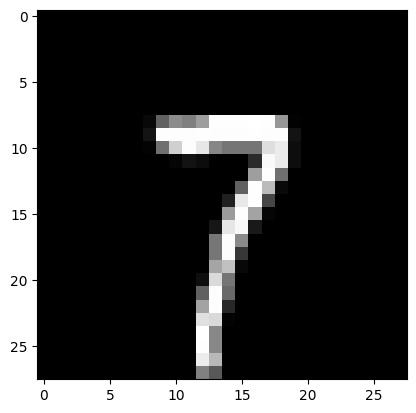

In [17]:
test_prediction(22, W1, b1, W2, b2)